# NLP in Pyspark's MLlib Project

## Fake Job Posting Predictions

Indeed.com has just hired you to create a system that automatically flags suspicious job postings on it's website. It has recently seen an influx of fake job postings that is negativley impacting it's customer experience. Becuase of the high volume of job postings it receives everyday, their employees do have the capacity to check every posting so they would like prioritize which postings to review before deleting it. 

#### Your task
Use the attached dataset with NLP to create an alogorthim which automatically flags suspicious posts for review. 

#### The data
This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs.

**Data Source:** https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction

#### Have fun!

# NLP Project Pipeline

Agenda
1. Review Data (quality check)
2.Dealing with null values
2. Clean up the data (remove puncuation, special characters, etc.)
3. Tokenize text data
4. Remove Stopwords
5. Zero index our label column
5. Create an ML Pipeline (to streamline steps 3-5)
6. Vectorize Text column
     - Count Vectors
     - TF-IDF
     - Word2Vec
7. Train and Evaluate Model (classification)
8. View Predictions

In [1]:
# Install pyspark
!pip install pyspark
# import findspark
# findspark.init()
import os
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("NLP_Project").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 3.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=42eb5020a66cd9380d4e1f83153293eeab7c55aa53e66daaed509c9f36bf3c89
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
You are working with 1 core(s)


**Import Dependencies**

In [2]:
from pyspark.ml.feature import * #CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import * #col, udf,regexp_replace,isnull
from pyspark.sql.types import * #StringType,IntegerType
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# For pipeline development
from pyspark.ml import Pipeline 

In [3]:
from google.colab import files
upload = files.upload()

Saving fake_job_postings.csv to fake_job_postings.csv


## 1-Read dataset


In [4]:
df = spark.read.csv('fake_job_postings.csv', inferSchema=True, header=True)
df.show(1000)

+------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|job_id|               title|            location|          department|   salary_range|     company_profile|         description|        requirements|            benefits|       telecommuting|    has_company_logo|       has_questions|     employment_type| required_experience|  required_education|            industry|            function|          fraudulent|
+------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--

In [5]:
df.limit(1000).toPandas()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,None,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,None,0,1,0,Other,Internship,None,None,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,None,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",None,None,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,None,0,1,0,None,None,None,None,None,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,None,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",None,None,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Data Analyst,"US, CA, San Francisco",None,None,Intercom (#URL_cb674f93cbcd215a3a0a57a8615a565...,About the jobAt Intercom we believe that data ...,A proven track record of initiating and delive...,Stock option grants in a fast growing companyC...,0,1,1,Full-time,Associate,None,Internet,Data Analyst,0
996,997,Financial Analyst / Intermediate Accountant,"CA, BC, Langley",Finance,40000-55000,Great Customer Service from Start to FinishWha...,"Centra Construction Group, a well established,...",The successful applicant will have the followi...,None,0,1,1,Full-time,Mid-Senior level,Certification,Construction,Finance,0
997,998,EXECUTIVE SOUS CHEF,"MY, ,",None,55000-65000,Le Meridien is situated in the heart of kuala ...,Responsible for assisting in the direction and...,None,None,0,1,0,Contract,Executive,None,Hospitality,None,1
998,999,Bookeeper/Supply Manager,"US, NY, Southampton",None,35000-45000,None,Full time Bookkeeper for local Southampton ene...,Heavy Quickbooks 2013 experience,MedicalPaid Time Off Policy,0,0,1,Full-time,Associate,None,Environmental Services,Accounting/Auditing,0


In [6]:
df.show(4,False)

+------+-----------------------------------------+------------------+----------+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
df.printSchema()

root
 |-- job_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- location: string (nullable = true)
 |-- department: string (nullable = true)
 |-- salary_range: string (nullable = true)
 |-- company_profile: string (nullable = true)
 |-- description: string (nullable = true)
 |-- requirements: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- telecommuting: string (nullable = true)
 |-- has_company_logo: string (nullable = true)
 |-- has_questions: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- required_experience: string (nullable = true)
 |-- required_education: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- function: string (nullable = true)
 |-- fraudulent: string (nullable = true)



**See how many rows are in the df?**

In [8]:
df.count()

17880

In [9]:
df_pandas=df.toPandas()
df_pandas

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,None,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,None,0,1,0,Other,Internship,None,None,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,None,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",None,None,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,None,0,1,0,None,None,None,None,None,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,None,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",None,None,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,None,Vend is looking for some awesome new talent to...,"""Just in case this is the first time you’ve vi...",To ace this role you:Will eat comprehensive St...,"""What can you expect from us?We have an open c...",Best Workplaces and obviously the most fun an...,apply now,hit that button,get it done and come have a chat with us. We ...,0,1,1,Full-time,Mid-Senior level
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,None,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",None,None,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,None,0,0,0,Full-time,None,None,None,None,0
17878,17879,Graphic Designer,"NG, LA, Lagos",None,None,None,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


## 2-Data Preparation and cleaning

2-A Dealing with target column 

Let's Check the target column (fraudulent)

In [10]:
df.select("fraudulent").show(1000,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
print(df_pandas.fraudulent.value_counts()[:10])

0                                                                               16080
1                                                                                 886
Full-time                                                                          73
Hospital & Health Care                                                             55
Bachelor's Degree                                                                  53
Engineering                                                                        26
 perform quality assurance of documents that have been flagged by the system       17
Mid-Senior level                                                                   15
Unspecified                                                                        15
Associate                                                                          14
Name: fraudulent, dtype: int64


Fraudulent Column has so many noisy data we have to get rid of them 

In [12]:
# Removing anything that is not (0 or 1) from target column
df = df.filter("fraudulent IN('0','1')")
df.select("fraudulent").show(1000,False)
df_pandas=df.toPandas()


+----------+
|fraudulent|
+----------+
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|1         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |
|0         |

In [13]:
print(df_pandas.fraudulent.value_counts()[:10])

0    16080
1      886
Name: fraudulent, dtype: int64


## 2-b Dealing with null values

### How many null values in the data set?

In [14]:
from pyspark.sql.functions import *

def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(df)
spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()

+-------------------+-----------------+------------------+
|        Column_Name|Null_Values_Count|Null_Value_Percent|
+-------------------+-----------------+------------------+
|           location|              337|1.9863255923611929|
|         department|            11039| 65.06542496758222|
|       salary_range|            14258| 84.03866556642697|
|    company_profile|             3206| 18.89661676293764|
|       requirements|             2571|15.153837085936578|
|           benefits|             6949| 40.95838736296122|
|    employment_type|             3273| 19.29152422492043|
|required_experience|             6675| 39.34339266768832|
| required_education|             7661|  45.1550159141813|
|           industry|             4667|27.507957090651892|
|           function|             6158|36.296121655074856|
+-------------------+-----------------+------------------+



<Axes: >

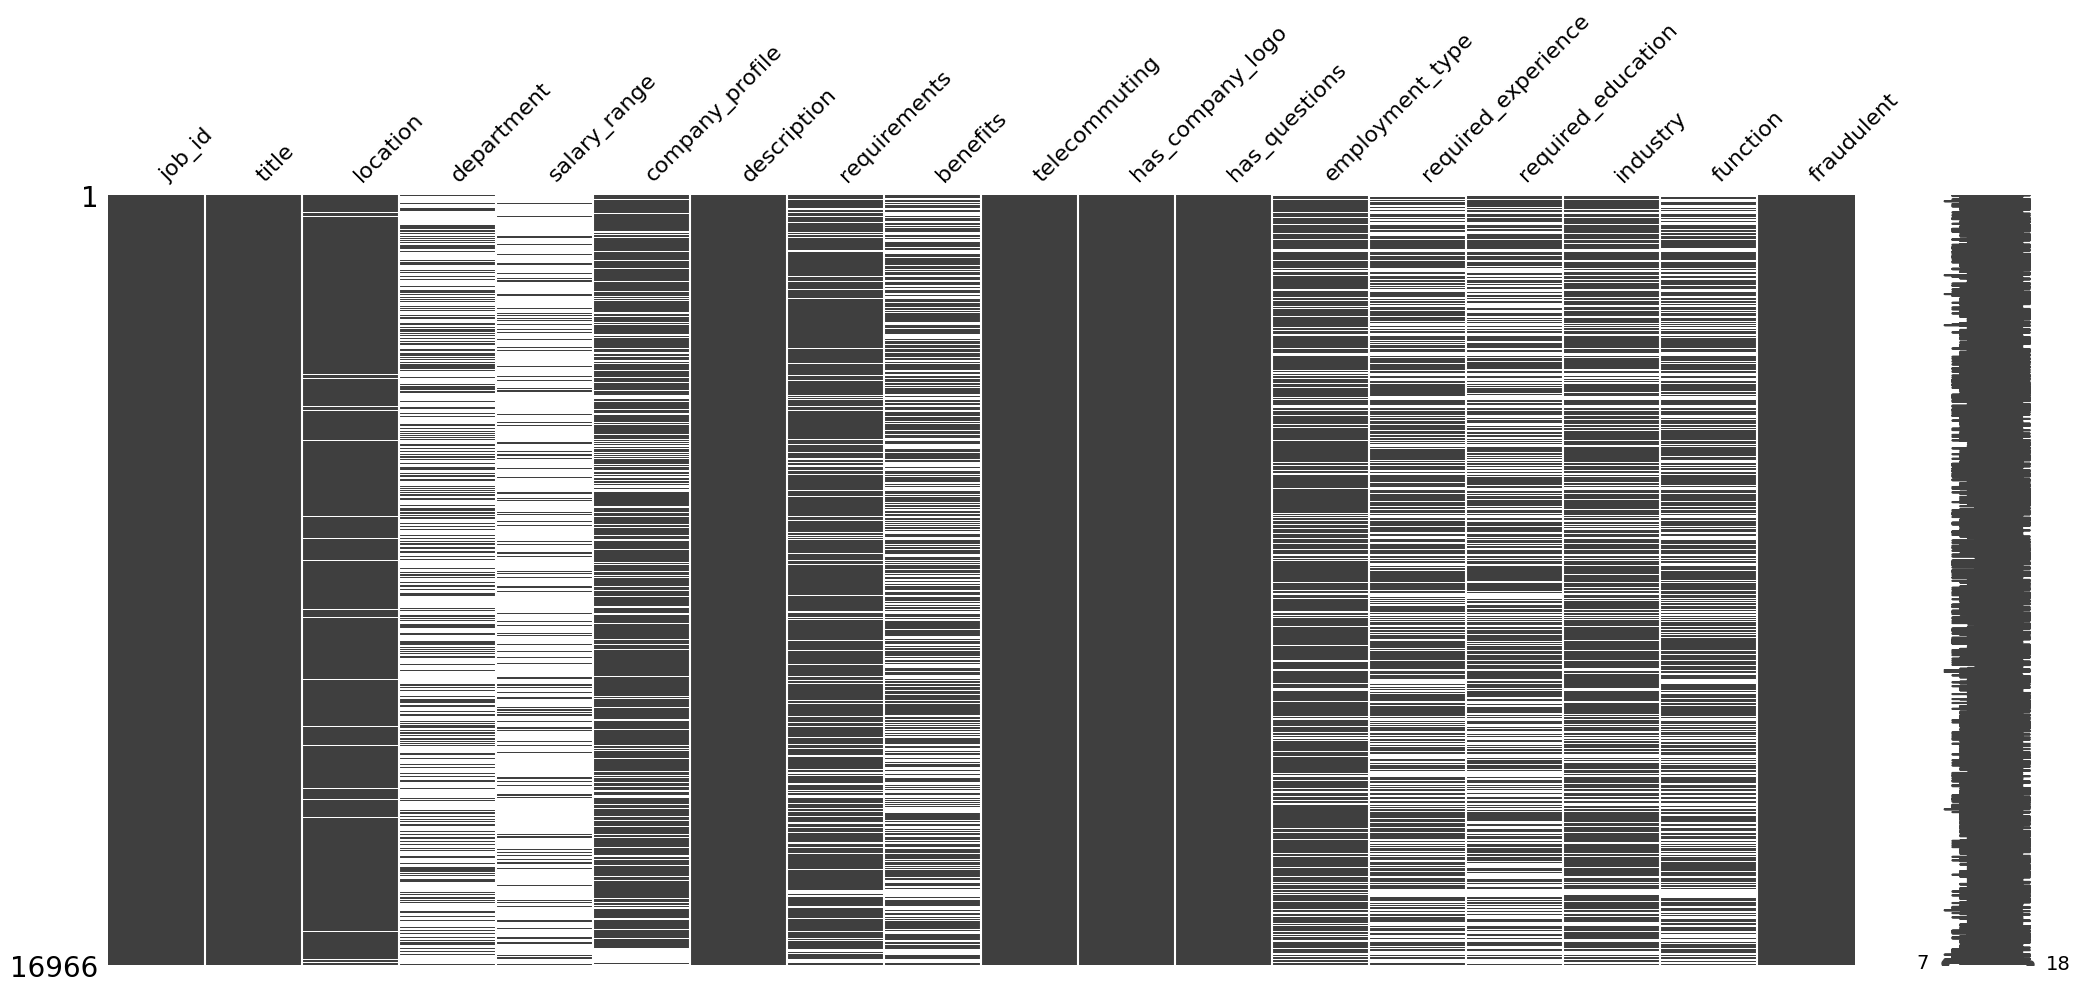

In [15]:
# plotting for missing values in data set
import missingno
missingno.matrix(df_pandas)

As the null values are not in the target column we will not drop them we will replace them with white space 

In [16]:
#Filling Null values in the data set 
df = df.na.fill(' ')
df.show()
df_pandas_fill=df.toPandas()


+------+--------------------+--------------------+----------+-------------+--------------------+--------------------+--------------------+--------------------+-------------+----------------+-------------+---------------+-------------------+--------------------+--------------------+--------------------+----------+
|job_id|               title|            location|department| salary_range|     company_profile|         description|        requirements|            benefits|telecommuting|has_company_logo|has_questions|employment_type|required_experience|  required_education|            industry|            function|fraudulent|
+------+--------------------+--------------------+----------+-------------+--------------------+--------------------+--------------------+--------------------+-------------+----------------+-------------+---------------+-------------------+--------------------+--------------------+--------------------+----------+
|     1|    Marketing Intern|    US, NY, New York| Mark

<Axes: >

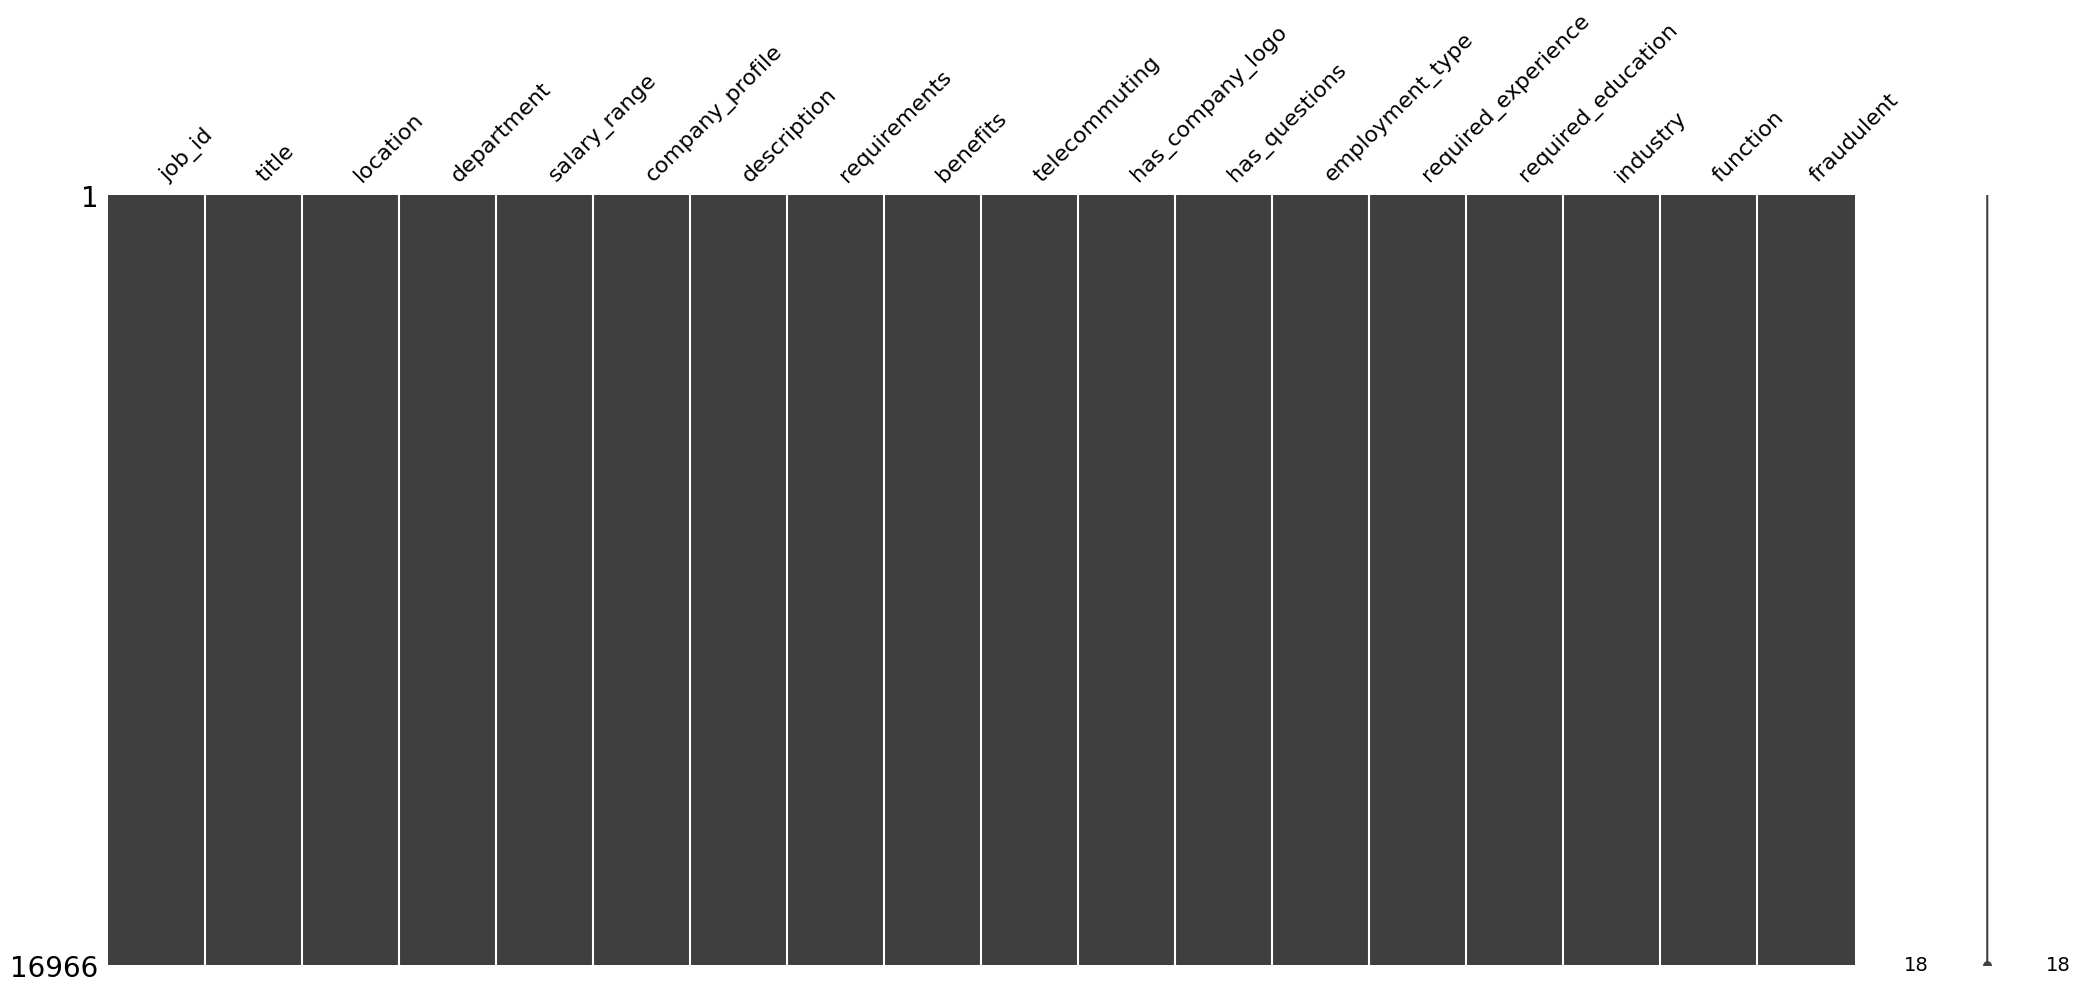

In [17]:
# Let's Make a check for missings after filling 
# plotting for missing values in data set
import missingno
missingno.matrix(df_pandas_fill)

No null values in the data 😊

## 3-Data Exploration 

<Axes: xlabel='fraudulent', ylabel='count'>

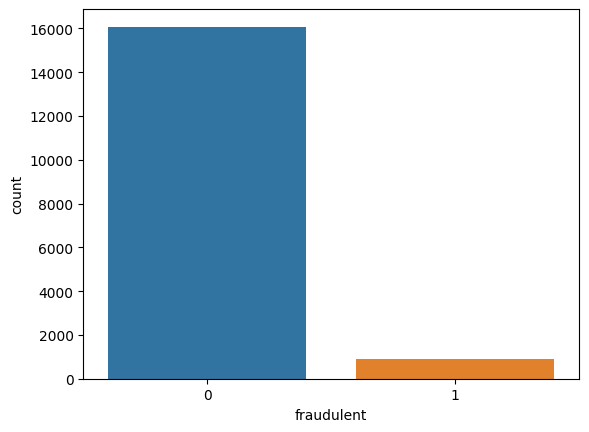

In [18]:
# Now lets see how many jobs posted are fraud and real.

df_pandas_fill['fraudulent'].value_counts()
sns.countplot(data=df_pandas_fill,x='fraudulent')
#df_pandas_fill.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

## 4-Data Preproceesing For NLP

## Concate all text columns in one column called TEXT

In [19]:
from pyspark.sql.functions import concat_ws,col
df=df.select("telecommuting","has_company_logo","has_questions","fraudulent",concat_ws('_',df.title,df.location,df.company_profile,df.department,df.description,df.requirements,df.benefits,df.employment_type,df.required_education,df.industry,df.function)
              .alias("text"),"fraudulent")
df.show(truncate=False)

+-------------+----------------+-------------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Get rid of the un nesessary columns 

In [20]:
cols_to_drop = ['job_id','salary_range','title','location','department','company_profile','description','requirements','benefits','employment_type','required_experience','required_education','industry','function' ]
df = df.drop(*cols_to_drop)
df.show()

+-------------+----------------+-------------+----------+--------------------+----------+
|telecommuting|has_company_logo|has_questions|fraudulent|                text|fraudulent|
+-------------+----------------+-------------+----------+--------------------+----------+
|            0|               1|            0|         0|Marketing Intern_...|         0|
|            0|               1|            0|         0|Customer Service ...|         0|
|            0|               1|            0|         0|Commissioning Mac...|         0|
|            0|               1|            0|         0|Account Executive...|         0|
|            0|               1|            1|         0|Bill Review Manag...|         0|
|            0|               0|            0|         0|Accounting Clerk_...|         0|
|            0|               1|            1|         0|Head of Content (...|         0|
|            0|               1|            1|         0|Lead Guest Servic...|         0|
|         

Text Cleaning 

In [21]:
# slash ,paranthesis and _
df= df.withColumn("text",translate(col("text"), "/", " ")) \
        .withColumn("text",translate(col("text"), "(", " ")) \
         .withColumn("text",translate(col("text"), "_", " ")) \
        .withColumn("text",translate(col("text"), ")", " "))
df.select("text").show(7,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
# Removing hashtags and links (starts with http or https)
df = df.withColumn("text",regexp_replace(col('text'), r'#\w+|http\S+', ''))
df.select("text").show(7,False)
    

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [23]:
# Remove multiple spaces
df = df.withColumn("text",regexp_replace(col('text'), ' +', ' '))
df.select("text").show(4,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [24]:
# Lower case everything
df = df.withColumn("text",lower(col('text')))
df.select("text").show(4,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
df.show()

+-------------+----------------+-------------+----------+--------------------+----------+
|telecommuting|has_company_logo|has_questions|fraudulent|                text|fraudulent|
+-------------+----------------+-------------+----------+--------------------+----------+
|            0|               1|            0|         0|marketing intern ...|         0|
|            0|               1|            0|         0|customer service ...|         0|
|            0|               1|            0|         0|commissioning mac...|         0|
|            0|               1|            0|         0|account executive...|         0|
|            0|               1|            1|         0|bill review manag...|         0|
|            0|               0|            0|         0|accounting clerk ...|         0|
|            0|               1|            1|         0|head of content m...|         0|
|            0|               1|            1|         0|lead guest servic...|         0|
|         

### Split text into words (Tokenizing)

Yo'll see a new column is added to our dataframe that we call "words". This column contains an array of strings as opposed to just a string (current data type of the blurb column).

In [26]:
regex_tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\W")
raw_words = regex_tokenizer.transform(df)
raw_words.show(10,False)
raw_words.printSchema() 

+-------------+----------------+-------------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Removing Stopwords

**Recall from the content review lecture**
Recall that "stopwords" are any word that we feel would "distract" our model from performing it's best. This list can be customized, but for now, we will just use the default list. 

In [27]:
# from pyspark.ml.feature import StopWordsRemover

# Define a list of stop words or use default list
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
stopwords = remover.getStopWords() 

# Display default list
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

In [28]:
words_df = remover.transform(raw_words)
words_df.limit(10).toPandas()

,telecommuting,has_company_logo,has_questions,fraudulent,text,fraudulent,words,filtered
0,0,1,0,0,"marketing intern us, ny, new york we're food52...",0,"[marketing, intern, us, ny, new, york, we, re,...","[marketing, intern, us, ny, new, york, re, foo..."
1,0,1,0,0,"customer service - cloud video production nz, ...",0,"[customer, service, cloud, video, production, ...","[customer, service, cloud, video, production, ..."
2,0,1,0,0,"commissioning machinery assistant cma us, ia, ...",0,"[commissioning, machinery, assistant, cma, us,...","[commissioning, machinery, assistant, cma, us,..."
3,0,1,0,0,"account executive - washington dc us, dc, wash...",0,"[account, executive, washington, dc, us, dc, w...","[account, executive, washington, dc, us, dc, w..."
4,0,1,1,0,"bill review manager us, fl, fort worth spotsou...",0,"[bill, review, manager, us, fl, fort, worth, s...","[bill, review, manager, us, fl, fort, worth, s..."
5,0,0,0,0,"accounting clerk us, md, job overviewapex is a...",0,"[accounting, clerk, us, md, job, overviewapex,...","[accounting, clerk, us, md, job, overviewapex,..."
6,0,1,1,0,"head of content m f de, be, berlin founded in ...",0,"[head, of, content, m, f, de, be, berlin, foun...","[head, content, m, f, de, berlin, founded, 200..."
7,0,1,1,0,"lead guest service specialist us, ca, san fran...",0,"[lead, guest, service, specialist, us, ca, san...","[lead, guest, service, specialist, us, ca, san..."
8,0,1,1,0,"hp bsm sme us, fl, pensacola solutions3 is a w...",0,"[hp, bsm, sme, us, fl, pensacola, solutions3, ...","[hp, bsm, sme, us, fl, pensacola, solutions3, ..."
9,0,1,0,0,"customer service associate - part time us, az,...",0,"[customer, service, associate, part, time, us,...","[customer, service, associate, part, time, us,..."


### Now we need to encode state column to a column of indices

Remember that MLlib requres our dependent variable to not only be a numeric data type, but also zero indexed. We can use Sparks handy built in StringIndexer function to accomplish this, just like we did in the classification lectures. 

Note: It's already indexed but we need it to be zero indexed 

In [29]:
indexer = StringIndexer(inputCol="fraudulent", outputCol="label")
feature_data = indexer.fit(words_df).transform(words_df)
feature_data.show(5)
feature_data.printSchema()

+-------------+----------------+-------------+----------+--------------------+----------+--------------------+--------------------+-----+
|telecommuting|has_company_logo|has_questions|fraudulent|                text|fraudulent|               words|            filtered|label|
+-------------+----------------+-------------+----------+--------------------+----------+--------------------+--------------------+-----+
|            0|               1|            0|         0|marketing intern ...|         0|[marketing, inter...|[marketing, inter...|  0.0|
|            0|               1|            0|         0|customer service ...|         0|[customer, servic...|[customer, servic...|  0.0|
|            0|               1|            0|         0|commissioning mac...|         0|[commissioning, m...|[commissioning, m...|  0.0|
|            0|               1|            0|         0|account executive...|         0|[account, executi...|[account, executi...|  0.0|
|            0|               1|  

## 5-ML Model 

## Creat an ML Pipeline

We could also create an ML Pipeline to accomplish the previous three steps in a more streamlined fashion. Pipelines allow users to combine any transformer call(s) and ONE estimator call in their ML workflow. Si a Pipeline can be a continuous set of transformer calls until you reach a point where you need to call ".fit()" which is an estimator call. 
<br>

Notice in the script below that we reduced our .transform calls from 3 to 1. So the benefit here is not necessarily speed but a bit less and more organized code (always nice) and little more streamlined. This feature can be esspecially useful when you get to the point where you want to move your model into production. You can save this pipeline to be called on whenever you need to prep new text. 

In [30]:

# Tokenize
regex_tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
# raw_words = regex_tokenizer.transform(df)

# Remove Stop words
remover = StopWordsRemover(inputCol=regex_tokenizer.getOutputCol(), outputCol="filtered")
# words_df = remover.transform(raw_words)

# Zero Index Label Column
indexer = StringIndexer(inputCol="fraudulent", outputCol="label")
# feature_data = indexer.fit(words_df).transform(words_df)

# Create the Pipeline
pipeline = Pipeline(stages=[regex_tokenizer,remover,indexer])
data_prep_pl = pipeline.fit(df)
# print(type(data_prep_pl))
# print(" ")
# Now call on the Pipeline to get our final df
feature_data = data_prep_pl.transform(df)
feature_data.show(1,False)

+-------------+----------------+-------------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Converting text into vectors

We will test out the following three vectorizors:

1. Count Vectors
2. TF-IDF
3. Word2Vec

In [31]:
# Count Vectorizer
cv = CountVectorizer(inputCol="filtered", outputCol="features")
fit_cv = cv.fit(feature_data)
countVectorizer_features = fit_cv.transform(feature_data)

In [32]:
# Hashing TF
hashingTF = HashingTF(inputCol="filtered", outputCol="rawfeatures", numFeatures=20)
HTFfeaturizedData = hashingTF.transform(feature_data)
# Pre-requisit for IDF
# Count Vector (count vectorizer and hashingTF are basically the same thing)
# cv = CountVectorizer(inputCol="filtered", outputCol="features")
# model = cv.fit(feature_data)
# countVectorizer_features = model.transform(feature_data)

In [33]:
# TF-IDF
idf = IDF(inputCol="rawfeatures", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)
TFIDFfeaturizedData.name = 'TFIDFfeaturizedData'

In [34]:
#rename the HTF features to features to be consistent
HTFfeaturizedData = HTFfeaturizedData.withColumnRenamed("rawfeatures","features")
HTFfeaturizedData.name = 'HTFfeaturizedData' #We will use later for printing

In [35]:
# Word2Vec
word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="filtered", outputCol="features")
model = word2Vec.fit(feature_data)

W2VfeaturizedData = model.transform(feature_data)
# W2VfeaturizedData.show(1,False)

In [36]:
# W2Vec Dataframes typically has negative values so we will correct for that here so that we can use the Naive Bayes classifier
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(W2VfeaturizedData)

# rescale each feature to range [min, max].
scaled_data = scalerModel.transform(W2VfeaturizedData)
W2VfeaturizedData = scaled_data.select('fraudulent','text','label','scaledFeatures')
W2VfeaturizedData = W2VfeaturizedData.withColumnRenamed('scaledFeatures','features')

W2VfeaturizedData.name = 'W2VfeaturizedData' # We will need this to print later

## Train and Evaluate your model

From here on out, is straight up classification. So we can go and use our trusty function! I'll just go ahead and copy and paste it in here.

In [37]:
def ClassTrainEval(classifier,features,classes,train,test):

    def FindMtype(classifier):
        # Intstantiate Model
        M = classifier
        # Learn what it is
        Mtype = type(M).__name__
        
        return Mtype
    
    Mtype = FindMtype(classifier)
    

    def IntanceFitModel(Mtype,classifier,classes,features,train):
        
        if Mtype == "OneVsRest":
            # instantiate the base classifier.
            lr = LogisticRegression()
            # instantiate the One Vs Rest Classifier.
            OVRclassifier = OneVsRest(classifier=lr)
#             fitModel = OVRclassifier.fit(train)
            # Add parameters of your choice here:
            paramGrid = ParamGridBuilder() \
                .addGrid(lr.regParam, [0.1, 0.01]) \
                .build()
            #Cross Validator requires the following parameters:
            crossval = CrossValidator(estimator=OVRclassifier,
                                      estimatorParamMaps=paramGrid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=2) # 3 is best practice
            # Run cross-validation, and choose the best set of parameters.
            fitModel = crossval.fit(train)
            return fitModel
        if Mtype == "MultilayerPerceptronClassifier":
            # specify layers for the neural network:
            # input layer of size features, two intermediate of features+1 and same size as features
            # and output of size number of classes
            # Note: crossvalidator cannot be used here
            features_count = len(features[0][0])
            layers = [features_count, features_count+1, features_count, classes]
            MPC_classifier = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
            fitModel = MPC_classifier.fit(train)
            return fitModel
        if Mtype in("LinearSVC","GBTClassifier") and classes != 2: # These classifiers currently only accept binary classification
            print(Mtype," could not be used because PySpark currently only accepts binary classification data for this algorithm")
            return
        if Mtype in("LogisticRegression","NaiveBayes","RandomForestClassifier","GBTClassifier","LinearSVC","DecisionTreeClassifier"):
  
            # Add parameters of your choice here:
            if Mtype in("LogisticRegression"):
                paramGrid = (ParamGridBuilder() \
#                              .addGrid(classifier.regParam, [0.1, 0.01]) \
                             .addGrid(classifier.maxIter, [10, 15,20])
                             .build())
                
            # Add parameters of your choice here:
            if Mtype in("NaiveBayes"):
                paramGrid = (ParamGridBuilder() \
                             .addGrid(classifier.smoothing, [0.0, 0.2, 0.4, 0.6]) \
                             .build())
                
            # Add parameters of your choice here:
            if Mtype in("RandomForestClassifier"):
                paramGrid = (ParamGridBuilder() \
                               .addGrid(classifier.maxDepth, [2, 5, 10])
#                                .addGrid(classifier.maxBins, [5, 10, 20])
#                                .addGrid(classifier.numTrees, [5, 20, 50])
                             .build())
                
            # Add parameters of your choice here:
            if Mtype in("GBTClassifier"):
                paramGrid = (ParamGridBuilder() \
#                              .addGrid(classifier.maxDepth, [2, 5, 10, 20, 30]) \
#                              .addGrid(classifier.maxBins, [10, 20, 40, 80, 100]) \
                             .addGrid(classifier.maxIter, [10, 15,50,100])
                             .build())
                
            # Add parameters of your choice here:
            if Mtype in("LinearSVC"):
                paramGrid = (ParamGridBuilder() \
                             .addGrid(classifier.maxIter, [10, 15]) \
                             .addGrid(classifier.regParam, [0.1, 0.01]) \
                             .build())
            
            # Add parameters of your choice here:
            if Mtype in("DecisionTreeClassifier"):
                paramGrid = (ParamGridBuilder() \
#                              .addGrid(classifier.maxDepth, [2, 5, 10, 20, 30]) \
                             .addGrid(classifier.maxBins, [10, 20, 40, 80, 100]) \
                             .build())
            
            #Cross Validator requires all of the following parameters:
            crossval = CrossValidator(estimator=classifier,
                                      estimatorParamMaps=paramGrid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=2) # 3 + is best practice
            # Fit Model: Run cross-validation, and choose the best set of parameters.
            fitModel = crossval.fit(train)
            return fitModel
    
    fitModel = IntanceFitModel(Mtype,classifier,classes,features,train)
    
    # Print feature selection metrics
    if fitModel is not None:
        
        if Mtype in("OneVsRest"):
            # Get Best Model
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype + '\033[0m')
            # Extract list of binary models
            models = BestModel.models
            for model in models:
                print('\033[1m' + 'Intercept: '+ '\033[0m',model.intercept,'\033[1m' + '\nCoefficients:'+ '\033[0m',model.coefficients)

        if Mtype == "MultilayerPerceptronClassifier":
            print("")
            print('\033[1m' + Mtype," Weights"+ '\033[0m')
            print('\033[1m' + "Model Weights: "+ '\033[0m',fitModel.weights.size)
            print("")

        if Mtype in("DecisionTreeClassifier", "GBTClassifier","RandomForestClassifier"):
            # FEATURE IMPORTANCES
            # Estimate of the importance of each feature.
            # Each feature’s importance is the average of its importance across all trees 
            # in the ensemble The importance vector is normalized to sum to 1. 
            # Get Best Model
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype," Feature Importances"+ '\033[0m')
            print("(Scores add up to 1)")
            print("Lowest score is the least important")
            print(" ")
            print(BestModel.featureImportances)
            
            if Mtype in("DecisionTreeClassifier"):
                global DT_featureimportances
                DT_featureimportances = BestModel.featureImportances.toArray()
                global DT_BestModel
                DT_BestModel = BestModel
            if Mtype in("GBTClassifier"):
                global GBT_featureimportances
                GBT_featureimportances = BestModel.featureImportances.toArray()
                global GBT_BestModel
                GBT_BestModel = BestModel
            if Mtype in("RandomForestClassifier"):
                global RF_featureimportances
                RF_featureimportances = BestModel.featureImportances.toArray()
                global RF_BestModel
                RF_BestModel = BestModel

        if Mtype in("LogisticRegression"):
            # Get Best Model
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype," Coefficient Matrix"+ '\033[0m')
            print("You should compares these relative to eachother")
            print("Coefficients: \n" + str(BestModel.coefficientMatrix))
            print("Intercept: " + str(BestModel.interceptVector))
            global LR_coefficients
            LR_coefficients = BestModel.coefficientMatrix.toArray()
            global LR_BestModel
            LR_BestModel = BestModel

        if Mtype in("LinearSVC"):
            # Get Best Model
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype," Coefficients"+ '\033[0m')
            print("You should compares these relative to eachother")
            print("Coefficients: \n" + str(BestModel.coefficients))
            global LSVC_coefficients
            LSVC_coefficients = BestModel.coefficients.toArray()
            global LSVC_BestModel
            LSVC_BestModel = BestModel
        
   
    # Set the column names to match the external results dataframe that we will join with later:
    columns = ['Classifier', 'Result']
    
    if Mtype in("LinearSVC","GBTClassifier") and classes != 2:
        Mtype = [Mtype] # make this a list
        score = ["N/A"]
        result = spark.createDataFrame(zip(Mtype,score), schema=columns)
    else:
        predictions = fitModel.transform(test)
        MC_evaluator = MulticlassClassificationEvaluator(metricName="accuracy") # redictionCol="prediction",
        accuracy = (MC_evaluator.evaluate(predictions))*100
        Mtype = [Mtype] # make this a string
        score = [str(accuracy)] #make this a string and convert to a list
        result = spark.createDataFrame(zip(Mtype,score), schema=columns)
        result = result.withColumn('Result',result.Result.substr(0, 5))
        
    return result
    #Also returns the fit model important scores or p values

Declare the algorithims you want to test plus declare a list of all the different feature vectors we want to test out that we created above.

In [38]:
# from pyspark.ml.classification import *
# from pyspark.ml.evaluation import *
# from pyspark.sql import functions
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Comment out Naive Bayes if your data still contains negative values
classifiers = [
                LogisticRegression()
                ,OneVsRest()
               ,LinearSVC()
               ,NaiveBayes()
               ,RandomForestClassifier()
               ,GBTClassifier()
               ,DecisionTreeClassifier()
               ,MultilayerPerceptronClassifier()
              ] 

featureDF_list = [HTFfeaturizedData,TFIDFfeaturizedData,W2VfeaturizedData]

Loop through all feature types (hashingTF, TFIDF and Word2Vec)

In [39]:
for featureDF in featureDF_list:
    print('\033[1m' + featureDF.name," Results:"+ '\033[0m')
    train, test = featureDF.randomSplit([0.7, 0.3],seed = 11)
    features = featureDF.select(['features']).collect()
    # Learn how many classes there are in order to specify evaluation type based on binary or multi and turn the df into an object
    class_count = featureDF.select(countDistinct("label")).collect()
    classes = class_count[0][0]

    #set up your results table
    columns = ['Classifier', 'Result']
    vals = [("Place Holder","N/A")]
    results = spark.createDataFrame(vals, columns)

    for classifier in classifiers:
        new_result = ClassTrainEval(classifier,features,classes,train,test)
        results = results.union(new_result)
    results = results.where("Classifier!='Place Holder'")
    print(results.show(truncate=False))

HTFfeaturizedData  Results:
 
LogisticRegression  Coefficient Matrix
You should compares these relative to eachother
Coefficients: 
DenseMatrix([[-0.00386232, -0.05654458, -0.01045596, -0.00151054, -0.05048668,
              -0.00600973,  0.06027634,  0.01437562, -0.04390059, -0.00908915,
              -0.02736076,  0.00477316, -0.03506281,  0.00625538, -0.04051892,
               0.04384412,  0.03332398, -0.01004224,  0.03060504,  0.02729503]])
Intercept: [-1.9842791178673282]
 
OneVsRest
Intercept:  2.187106433100366 
Coefficients: [0.003477528129227778,0.00983026582748877,0.0032925507319409926,0.0027788121262092742,0.008572779714175464,0.00401627805176772,-0.0046387049508608835,0.0017358984527631514,0.00637881503248518,0.0033688085109925088,0.005444706554391674,0.0031199148156297995,0.006132658847369218,0.0012547629711912127,0.0069656693928793634,-0.0009552817855682814,6.221789575493381e-06,0.003193322646569398,-0.002051629260170206,-0.0024461715522915276]
Intercept:  -2.18710643310

As GBTClassifier has  best results we will choose it

In [40]:
classifier = GBTClassifier()
featureDF = W2VfeaturizedData

train, test = featureDF.randomSplit([0.7, 0.3],seed = 11)
features = featureDF.select(['features']).collect()

# Learn how many classes there are in order to specify evaluation type based on binary or multi and turn the df into an object
class_count = featureDF.select(countDistinct("label")).collect()
classes = class_count[0][0]

#running this afain with generate all the objects need to play around with test data
ClassTrainEval(classifier,features,classes,train,test)

 
GBTClassifier  Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
(3,[0,1,2],[0.3527916009802951,0.322974209081565,0.32423418993813985])


DataFrame[Classifier: string, Result: string]

## Test the model

In [42]:
predictions = GBT_BestModel.transform(test)
print("Predicted Failures:")
predictions.select("label","text").filter("prediction=0").orderBy(predictions["prediction"].desc()).show(3,False)
print(" ")
print("Predicted Success:")
predictions.select("label","text").filter("prediction=1").orderBy(predictions["prediction"].desc()).show(3,False)

Predicted Failures:
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------